BART - Bayesian Additive Regression Trees - was used to model data. Gradient Boosting Trees, more popular modelling technique, sums up trees using a small learning rate. In similar vein BART sums up trees using a prior. More info about the [theory](http://www.jstatsoft.org/article/view/v097i01) and the package.


Problem presented by the competition is regression of a seemingly discrete variable. Target variable *loss* has 43 unique values seperated by the increments of 1. *f1* is the only other variable that is an integer, though this information is probably unimportant.

In [1]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, ggplot2, ggthemes, cowplot, repr, BART)


#Loading in the competition data
df_train <- read.csv("../input/tabular-playground-series-aug-2021/train.csv")
df_test <- read.csv("../input/tabular-playground-series-aug-2021/test.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


BART installed



In [2]:
#Checking correlation between loss variable and other variables
cor_matrix <- df_train %>%
    dplyr::select(-id) %>%
           cor()

df_cor <- data.frame(id = 1:101)

for(i in 1:nrow(df_cor)) {
df_cor <- df_cor %>%
  cbind(cor_matrix[, i])
}

colnames(df_cor) <- colnames(df_train)


check_cor <- df_cor %>%
  dplyr::select(loss) %>%
  mutate(loss = abs(loss)) %>%
  arrange(desc(loss))

head(check_cor, 40)

rm(df_cor, check_cor, cor_matrix)
gc()

,loss
,<dbl>
loss,1.000000000
f25,0.030164077
f52,0.026565690
f13,0.025729843
f46,0.023828023
f58,0.023370463
f28,0.022780174
f66,0.022423762
f74,0.021610407


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2300069,122.9,8106530,433,9144341,488.4
Vcells,47398816,361.7,114809817,876,83069861,633.8


Checking the correlation between the target variable and predictors - correlation is minimal, almost non-existant.


In [3]:
#Normalize with train set values
normalize_function_train <- function(df, train) {
    for(i in 1:length(df)) {
        max_df <- max(train[, i])
        min_df <- min(train[, i])
            df[, i] <- (2*df[, i] - max_df - min_df)/(max_df - min_df)
        }
    return(df)
    }

Normalizing all predictor variables - modifying their value range to (-1,1) based on min and max values. Training data is used to normalize both sets to prevent data leakage.
Worth noting that normalized values are susceptible to outliers.

In [4]:
#Normalizing variables before plotting
norm_train <- df_train %>%
  dplyr::select(-id,-loss)

norm_test <- df_test %>%
    dplyr::select(-id)

norm_test <- normalize_function_train(norm_test, norm_train)
norm_train <- normalize_function_train(norm_train, norm_train)



#Creating a joint dataset
norm_joint <- norm_train %>%
    rbind(norm_test)


norm_plot <- norm_joint

norm_plot <- norm_plot %>%
  cbind(data = c(rep('train', 250000), rep('test', 150000)))

norm_plot <- norm_plot %>%
  mutate(data = as.factor(data))

#Removing temp dataframes
rm(norm_train, norm_test, norm_joint)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2304238,123.1,6485224,346.4,9144341,488.4
Vcells,89609580,683.7,167112208,1275.0,140616824,1072.9


For the sake of clarity values of each predictor variable are normalized before plotting.

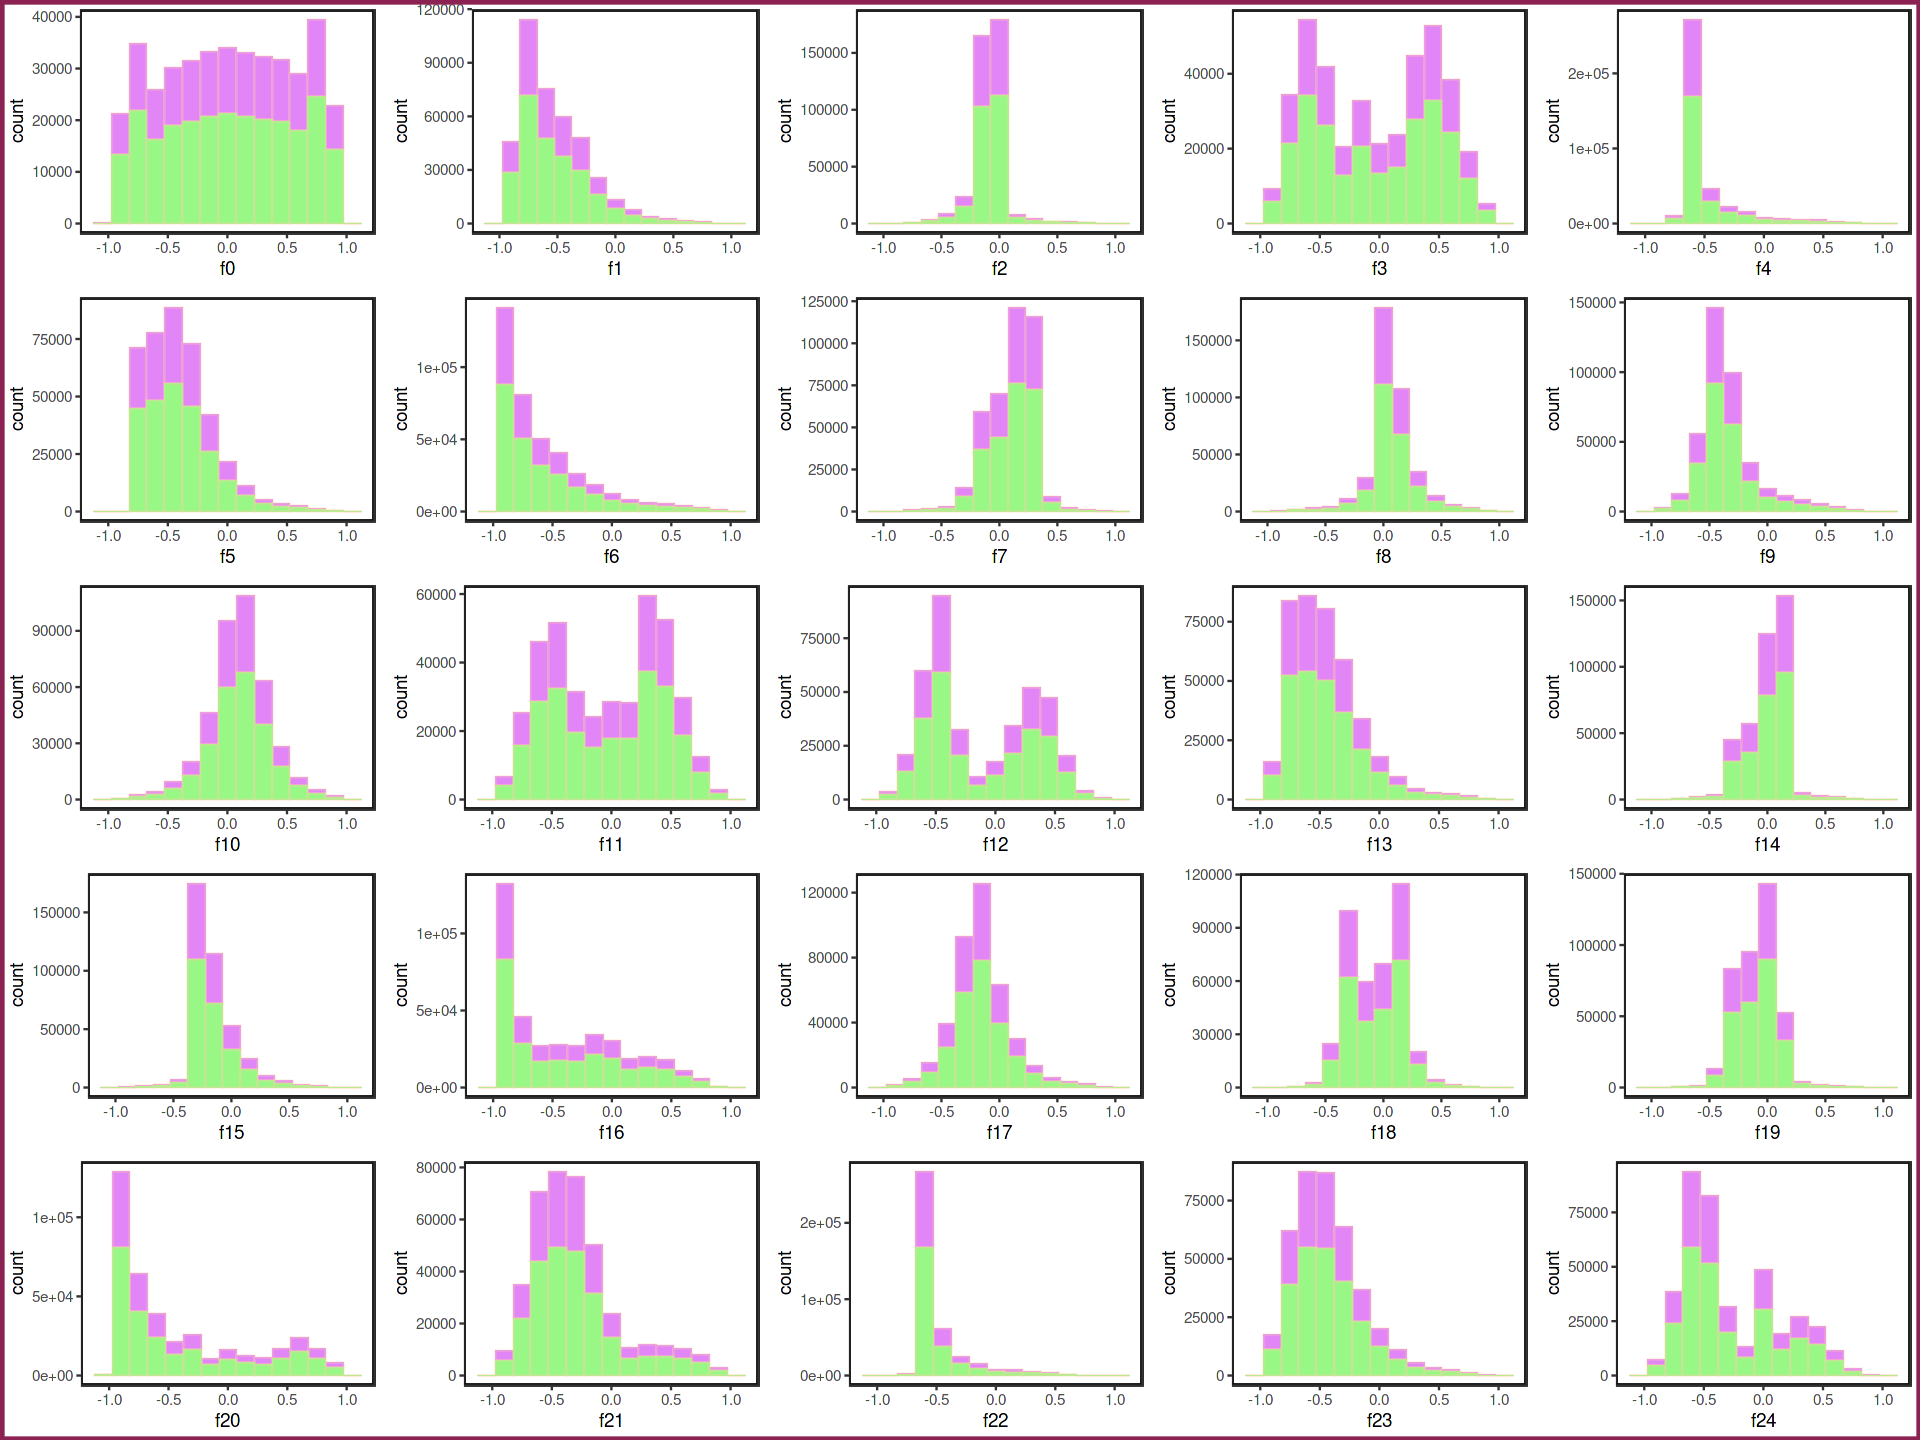

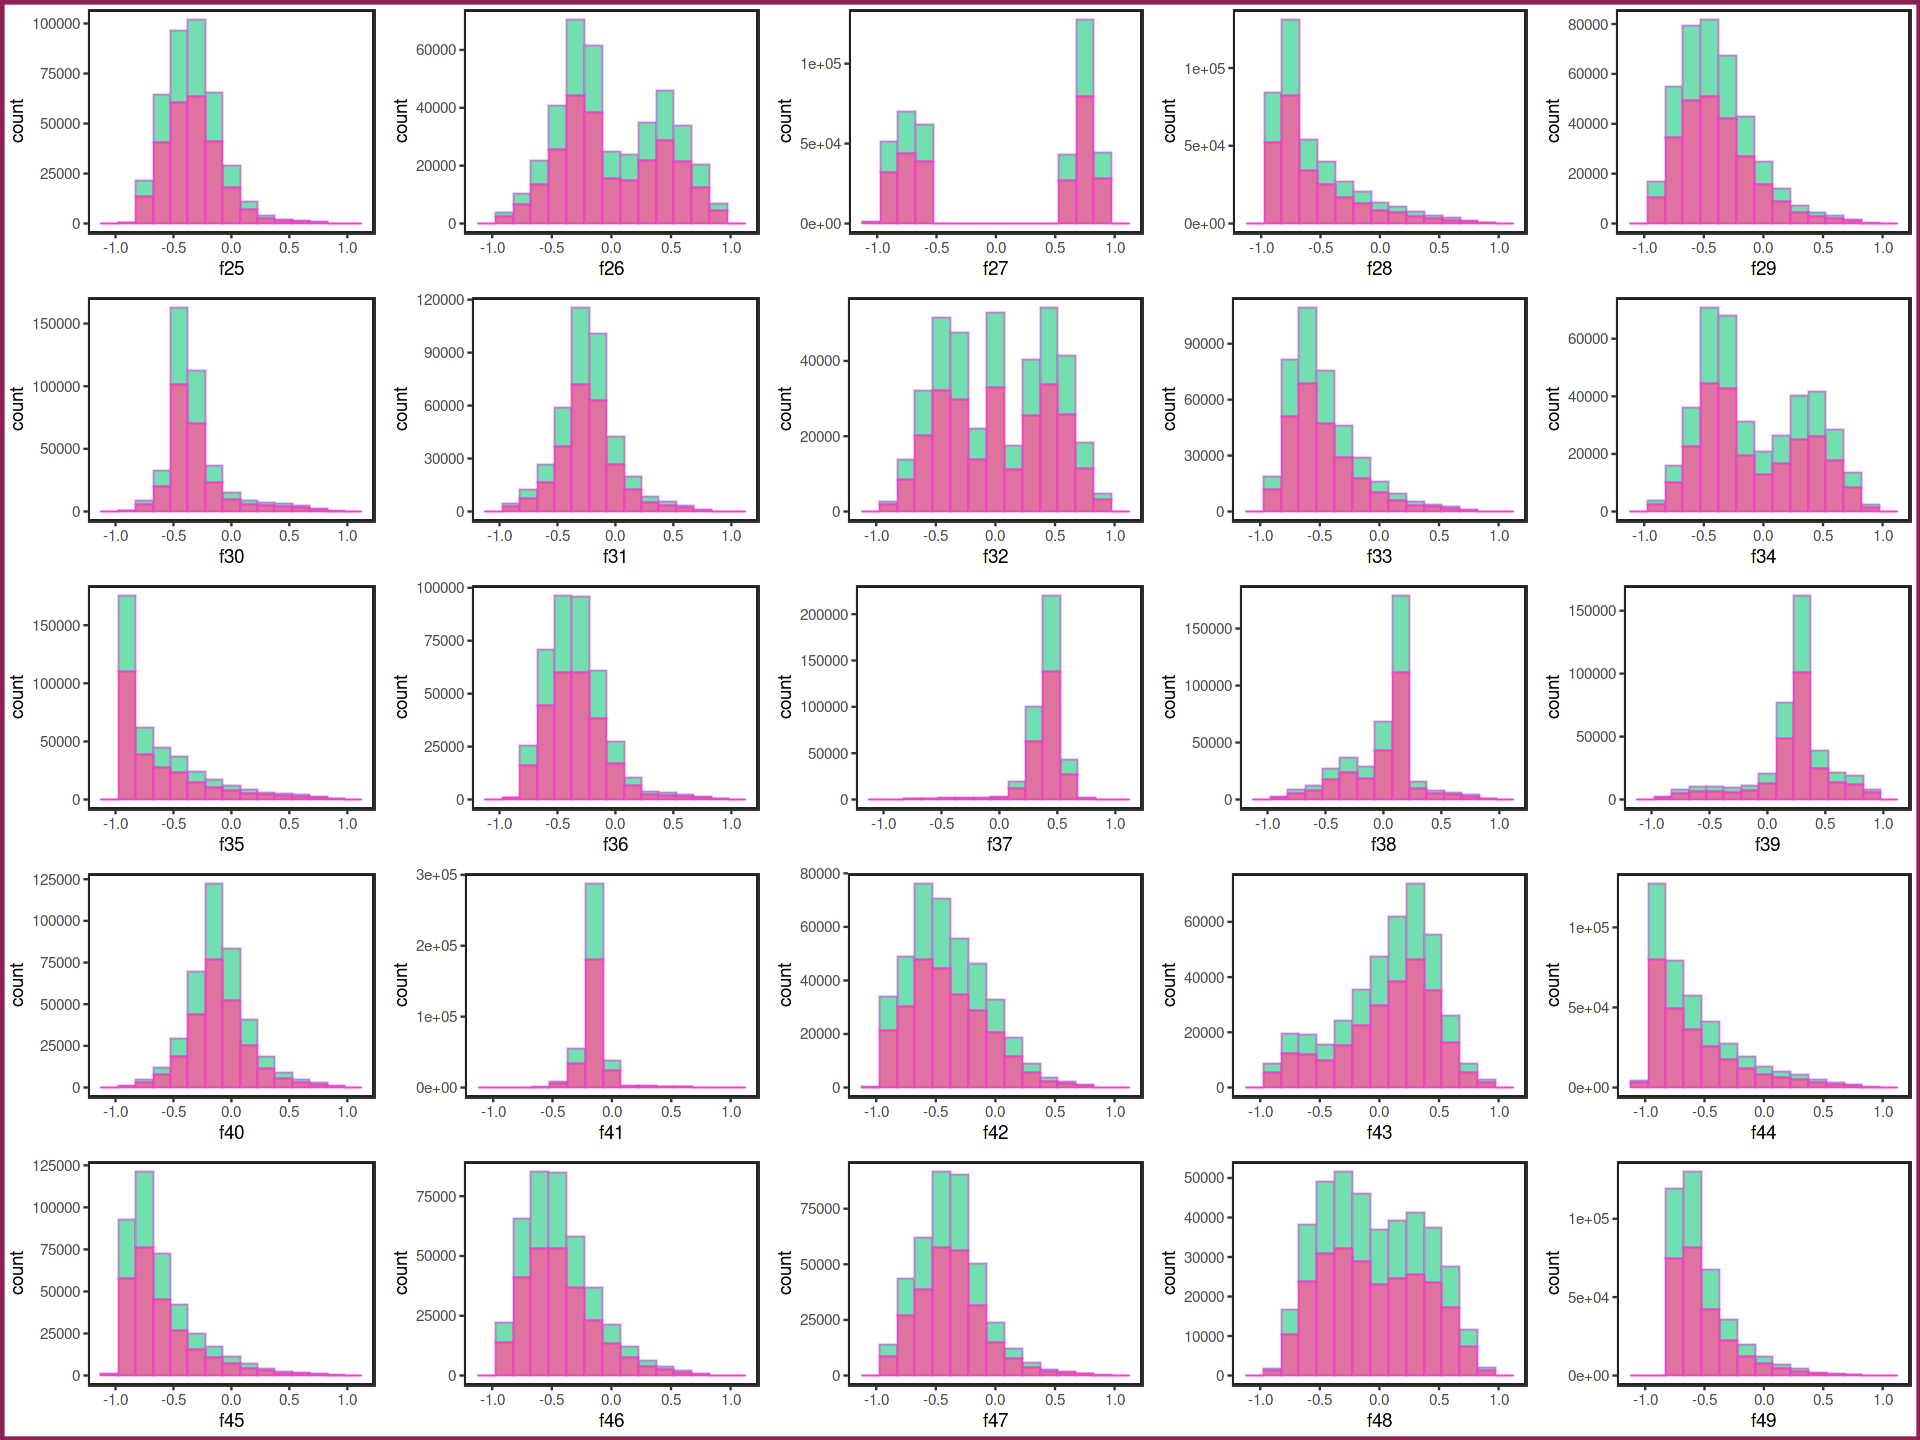

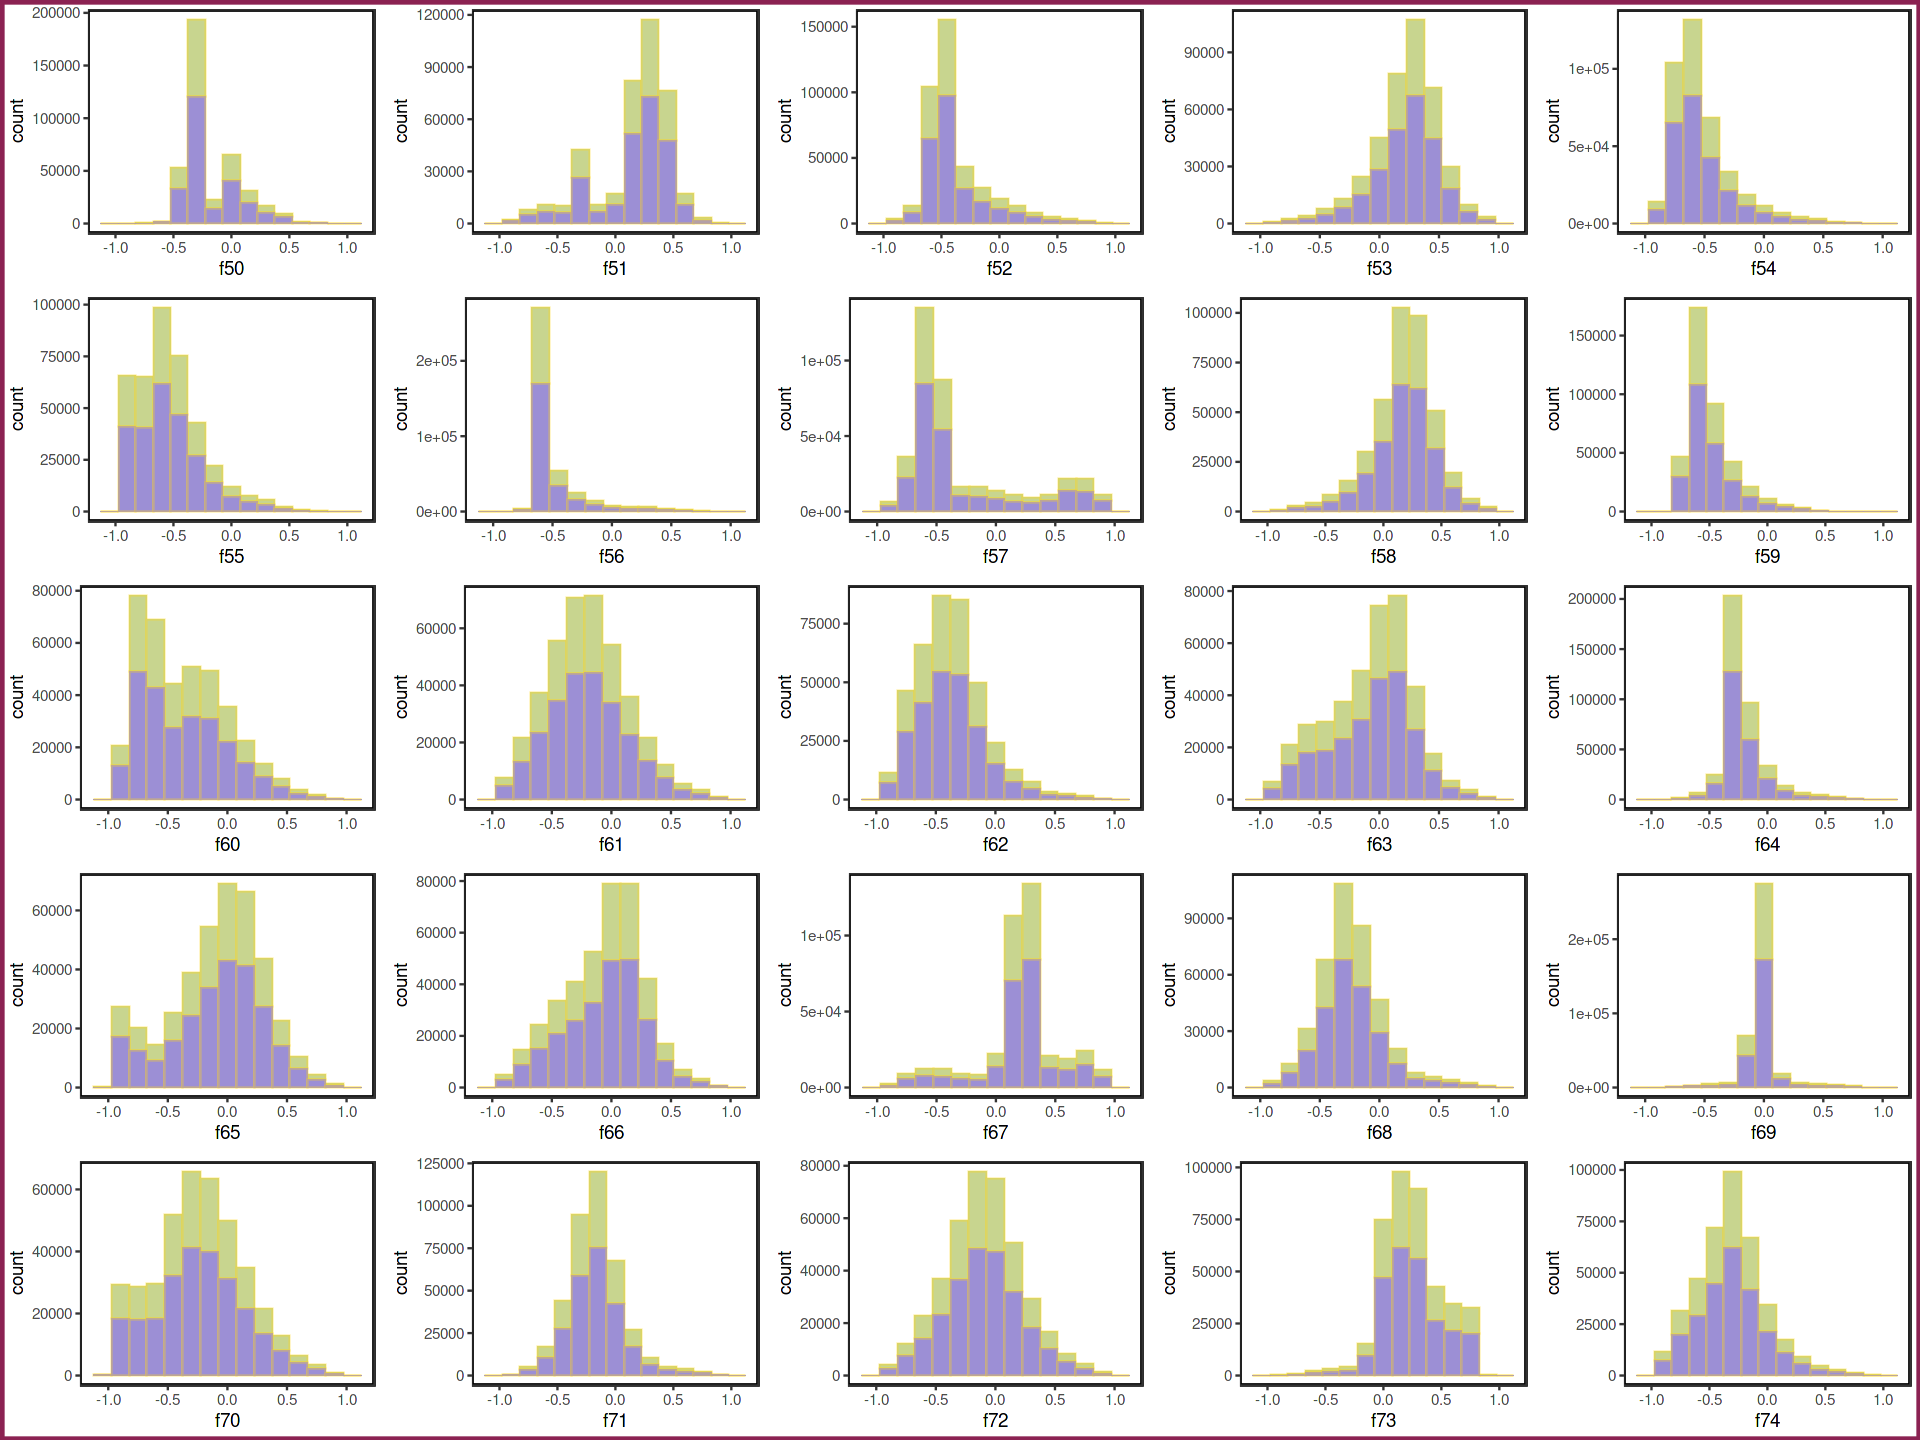

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3953873,211.2,6485224,346.4,9144341,488.4
Vcells,51479415,392.8,168273076,1283.9,168273076,1283.9


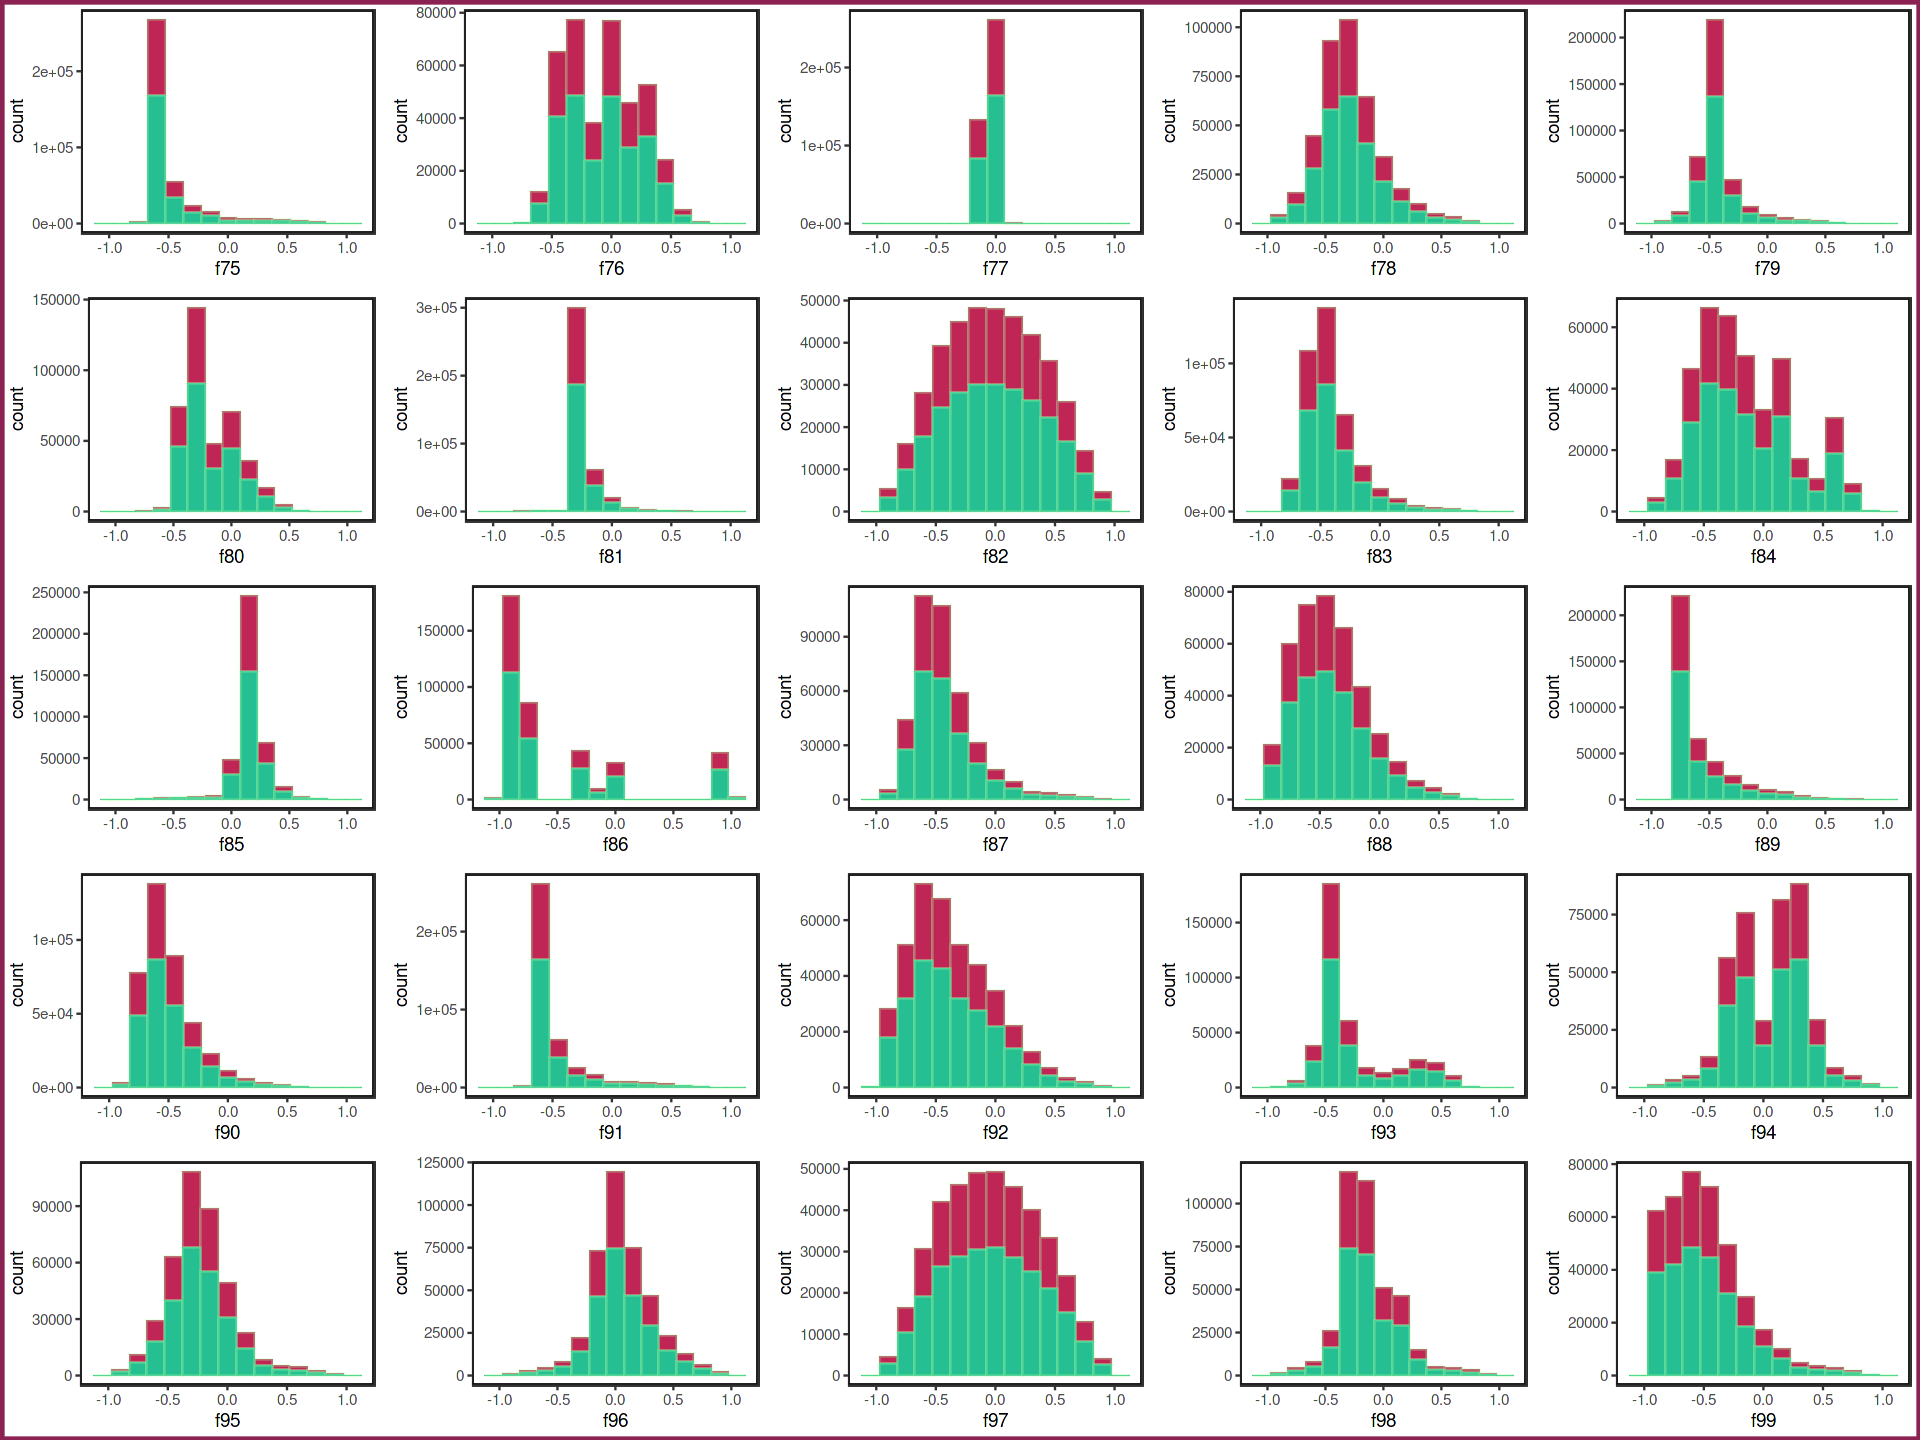

In [5]:
#Creating a list of plots
k <-1 
colour_index <- 1
    #Colour palette (border with 35% opacity)
colours <- list(c("#99F785", "#e285f7", "#ffceab59"), c("#de73a0", "#73deb0", "#ff00ea59"),
                     c("#9c8fd5", "#c8d58f", "#ffd41459"), c("#26bf91", "#bf2656", "#acffa359"))


for(i in seq(from = 25, to = 100, by = 25)) {
  plotlist <- list()
  plot_norm <- norm_plot[, c(k:i, 101)]
  for(j in 1:(length(plot_norm)-1)) {
    plotlist[[j]] <- local({
      colour_index <- colour_index
      colours <- colours
      j <- j
      plot_j <- ggplot(plot_norm, aes(x = plot_norm[[j]], fill = data)) +
        geom_histogram(binwidth = 0.15, show.legend = FALSE, colour = colours[[colour_index]][3]) +
        scale_fill_manual(      
          values = c("train" = colours[[colour_index]][1], 
                     "test" = colours[[colour_index]][[2]])) +
        theme_bw() + theme(panel.grid.major = element_blank(), 
                           panel.grid.minor = element_blank(),
                           panel.background = element_rect(colour = "black", fill = NA, size = 1)) +
        xlab(colnames(plot_norm)[j])
      
      
    })   
  }
  k <- k + 25
  colour_index <- colour_index + 1
  options(repr.plot.width = 16, repr.plot.height = 12)
  suppressWarnings(print(plot_grid(plotlist = plotlist, nrow = 5, ncol = 5) +
                           theme(panel.border = element_rect(colour = "violetred4", fill = NA , size = 1.75))))
}
rm(plotlist, colour_index, colours, plot_norm, norm_plot)
gc()

Histograms are presented in 4 5x5 grids to save memory. Data frame prepared for plotting contained 101 variables - 100 predictor variables and a ('train' or 'test') factor variable. Local environment was used to store plots in an array and print them.

Some distributions show sparsity (e.g. f77 f69, f41, f2) although it might be attributed to the chosen binwidth. Train and test set share similar distributions with small differences.

$x
[1] "loss"

attr(,"class")
[1] "labels"

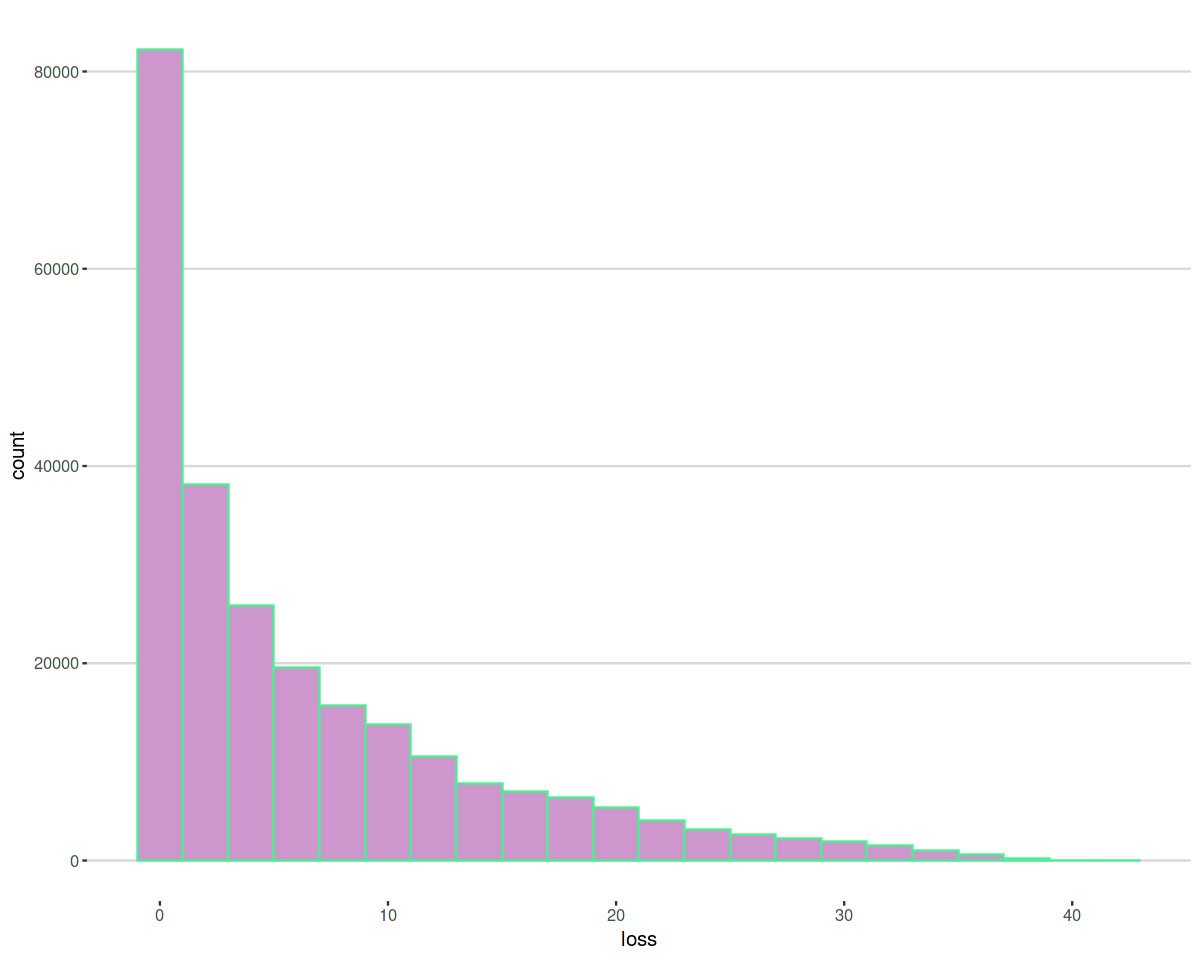

In [6]:
#Plotting the histogram of loss target variable
options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df_train, aes(x = loss)) +
geom_histogram(colour = "seagreen2", fill = "plum3", binwidth = 2, show.legend = FALSE) + theme_hc()
xlab(colnames(df_train)[length(df_train)])


Target variable shows a right-skewed distribution with 0 being the prevalent value.

# *Pseudo CV*

In [7]:
#Variable deciding whether to perform CV or not
    #To save memory, value of 0 was chosen
execute <- 0

if(execute == 1) {

#Sampling the data
set.seed(2040)
strat_df_train <- df_train %>%
  group_by(loss) %>%
  sample_frac(size = 0.32) %>% #Chosen fraction of the data
  ungroup()



#Scrambling the data (data is grouped)
set.seed(2040)
scramble_num <- sample(nrow(strat_df_train))
strat_df_train <- strat_df_train[scramble_num, ]

strat_df_train <- strat_df_train %>%
    dplyr::select(-id)
}


32% of data is sampled for cross validation, grouped by the loss variable (stratified sampling). Then it's scrambled and normalized.

In [8]:
if(execute == 1) {

#Spltting the data and setting up cv
k_num <- 5

set.seed(2040)
df_list <- strat_df_train %>%
  group_by((row_number()-1) %/% (n()/k_num)) %>%
  nest %>% pull(data)



combinations <- combn(rep(1:5), 3)
list_comb <- lapply(seq_len(ncol(combinations)), function(i) combinations[,i])


'%notin%' <- Negate('%in%')

for(j in c(-15.5,-16,-17)) {
#Predefining arrrays
y <- 1

not_array <- c()

rmse_array <- c()

#Pseudo cv loop

for(i in 1:length(list_comb)) {
not_array <- which(c(1,2,3,4,5) %notin% list_comb[[i]])

k_train <- df_list[[list_comb[[i]][1]]] %>%
  rbind(df_list[[list_comb[[i]][2]]]) %>%
  rbind(df_list[[list_comb[[i]][3]]])

k_test <- df_list[[not_array[1]]] %>%
  rbind(df_list[[not_array[2]]])
    
#Creating matrices and isolating target variable
k_train_label <- k_train$loss

k_test_label <- k_test$loss

k_train <- k_train %>%
    dplyr::select(-loss)
    
k_test <- k_test %>%
    dplyr::select(-loss)

#Normalizing values of train and test sets
    #Since result of the function on variable k_train is assigned to the variable itself,
    #normalization is performed on k_test variable first (if the reverse were true, max and min values would be 1 and -1)
k_test <- normalize_function_train(k_test, k_train)  
k_train <- normalize_function_train(k_train, k_train)

    
k_train_matrix <- data.matrix(k_train, rownames.force = NA)

k_test_matrix <- data.matrix(k_test, rownames.force = NA)

  
  #Creating a baseline model
  bart_model_traintest <- mc.wbart(
    x.train = k_train_matrix,
    y.train = k_train_label,
    x.test = k_test_matrix,
    sparse = FALSE,
    theta = 0, omega = 1,
    a = 0.7, b = 1, k = 5,
    power = 5, base = 0.75,
    fmean = -5,
    sigmaf = j,
    sigquant = 0.2,
    lambda = 3,
    augment = FALSE, usequants = TRUE,
    rho = 100,
    ntree = 250, numcut = nrow(k_train_matrix)-1, ndpost = 1000,
    nskip = 20, transposed = FALSE,
    seed = 101010)
  
  
  #print(summary(bart_model_traintest$yhat.test.mean))
  #print(i)
  rmse_array[y] <- Metrics::rmse(k_test_label, bart_model_traintest$yhat.test.mean)
  print(rmse_array[y])   
  y <- y+1
}
cat(sprintf("tested_value: %s\n", j))
cat(sprintf("cv_mean: %s\n", mean(rmse_array)))
    }

}
        

Since cross validation isn't included in the BART package, this is a patchwork version. If data is split into (n = 5) parts (0.2 of sampled dataset each), and a 0.6 / 0.4 training - test split is chosen (k = 3), there are 10 possible combinations, taken the order doesn't matter:
  \begin{align}
n \choose k &= \frac{n!}{k!\thinspace (n-k)!} \,= \frac{5!}{3!\thinspace (5-3)!} \,= 10 \\
  \end{align}
  
Created combinations are put into a list of arrays and then training set is created by binding specific rows. Test set is created by checking which elements from the whole set weren't used and combining those.

# *Test data model*

In [9]:
#Creating training and test matrices
train_matrix <- df_train %>%
    dplyr::select(-id, -loss)

test_matrix <- df_test %>%
    dplyr::select(-id)


#Normalizing values
test_matrix <- normalize_function_train(test_matrix, train_matrix)

train_matrix <- normalize_function_train(train_matrix, train_matrix)


train_matrix <- data.matrix(train_matrix, rownames.force = NA)
test_matrix <- data.matrix(test_matrix, rownames.force = NA)


train_label <- df_train$loss

#Removing temporary joint dataframe
rm(df_train, df_test)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2416393,129.1,6485224,346.4,9144341,488.4
Vcells,72923900,556.4,168273076,1283.9,168273076,1283.9


In [10]:
#Predicting on test data
wbart_model_traintest <- mc.wbart(
    x.train = train_matrix,
    y.train = train_label,
    x.test = test_matrix,
    sparse = FALSE,
    theta = 0, omega = 1,
    a = 0.7, b = 1, k = 5,
    power = 5, base = 0.75,
    fmean = 12,
    sigmaf = 11,
    sigquant = 0.2,
    lambda = 2.3,
    w = rep(1.1,length(train_label)),
    augment = FALSE, usequants = TRUE,
    ntree = 700,
    rho = 100, #Number of covariates to use
    numcut = nrow(train_matrix)-1, #Cutoff
    ndpost = 900, #MCMC draws
    nskip = 20, #Burn-in
    transposed = FALSE,
    seed = 101010)

Model fit was checked with a pseudo cross-validation.
Above hyperparameter values were a result of couple of grid searches.

Possible augmentations:
* Vector of weights for covariates
* More thorough grid search of hyperparameters
* Modifying covariate values - trimming outliers (unlikely to help)
* Informed variable selection

In [11]:
wbart_outcome <- wbart_model_traintest$yhat.test.mean

#Removing the model
rm(wbart_model_traintest)
gc()

summary(wbart_outcome)

df_outcome_wbart <- data.frame(id = 250000:399999, loss = wbart_outcome)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2420981,129.3,6485224,346.4,9144341,488.4
Vcells,73084120,557.6,1304241877,9950.6,1372438662,10470.9


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6886  5.9687  6.7867  6.8095  7.6206 13.6046 

In [12]:
write.csv(df_outcome_wbart, "./wbart_hyper_cv.csv", quote = FALSE, row.names = FALSE)